In [1]:
# load both dataframes
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb

original_df = pd.read_csv("./spreadsheets/reflacx_clinical.csv")
original_clinical_cols = [
    "temperature",
    "heartrate",
    "resprate",
    "o2sat",
    "sbp",
    "dbp",
    'age',
    'gender'
]
chexpert_label_cols = [col for col in original_df if col.endswith("chexpert") and col != 'No Finding_chexpert']


In [2]:
TOP5_LABEL_COLS = [
    # "Fibrosis",
    # "Quality issue",
    # "Wide mediastinum",
    # "Fracture",
    # "Airway wall thickening",
    ######################
    # "Hiatal hernia",
    # "Acute fracture",
    # "Interstitial lung disease",
    # "Enlarged hilum",
    # "Abnormal mediastinal contour",
    # "High lung volume / emphysema",
    # "Pneumothorax",
    # "Lung nodule or mass",
    # "Groundglass opacity",
    ######################
    "Pulmonary edema",
    "Enlarged cardiac silhouette",
    "Consolidation",
    "Atelectasis",
    "Pleural abnormality",
    # "Support devices",
]

In [3]:
identified_keywords = {
    "pulmonary consolidation": {
        "boolean": [
            "area of white lung on x-ray",
            "bronchial breath sounds",
            "impaired percussion note",
            "increased vocal fremitus",
            "increased vocal resonance",
            "lower pao2 than calculated in the alveolar gas equation",
            "possible crackles",
            "possible presence of a pleural rub",
            "reduced expansion of the thorax on inspiration",
        ],
        "numerical": [],
    },
    "pleural abnormality": {
        "boolean": [
            "bone fractures",
            "heart failure",
            "hiatal hernia",
            "interstitial lung disease",
            "plaques",
            "pleural effusions",
            "pleural thickening",
            "pneumonia",
            "pneumothorax",
            "pulmonary tuberculosis",
        ],
        "numerical": [],
    },
    "enlarged cardiac silhouette": {
        "boolean": [
            "anxiety",
            "back pain",
            "cardiac tamponade",
            "decreased alertness",
            "diaphoresis",
            "distant heart sounds",
            "distension of the jugular vein",
            "dry cough",
            "electrical alternans on ekg",
            "electrical alternans on holter monitor",
            "fatigue",
            "fever",
            "fluid around the heart",
            "friction rub",
            "left precordial pleuritic chest pain",
            "neck pain",
            "pain in the shoulders",
            "palpitations",  # can be heart-rate. (increased heart-rate)
            "pericardial effusion",
            "positional chest pain",
            "pulsus paradoxus",
            "radiation to the trapezius ridge",
            "relief of pain by bending forward",
            "relief of pain by sitting up",
            "shortness of breath",
            "specific electrocardiogram (ecg) changes",
            "substernal pain",
            "sudden onset of sharp chest pain",
            "weakness",
            "worsening of pain by inspiration",
            "worsening of pain by lying down",
        ],
        "numerical": [
            "systolic blood pressure (mmHg)",  # "low blood pressure"
            "diastolic blood pressure (mmHg)",  # "equilibration of diastolic blood pressures",
        ],
    },
    "pulmonary edema": {
        "boolean": [
            "chest pain",
            "congestive heart failure",
            "coughing",
            "dyspnea",
            "frothy sputum",
            "heart valve dysfunction",
            "hypertensive crisis",
            "hypoxemia",
            "impaired gas exchange",
            "impaired left ventricular function",
            "increased microvascular permeability",
            "pericardial tamponade",
            "respiratory failure",
            "volume overload",
            "wheezing",
        ],
        "numerical": [],
    },
    "atelectasis": {
        "boolean": [
            "anesthesia",
            "asthma",
            "asymptomatic",
            "breathing difficulty",
            "chest pain",
            "chronic obstructive pulmonary disease",
            "cough",    
            "cyanosis",
            "fever",
            "pleural effusion",
            "pulmonary tuberculosis",
            "small volume linear shadows",
            "smoking",
        ],
        "numerical": [
            "heart rate (per minute)",  # increased heart-rate.
            "oxygen saturation (%)",  # reduced oxygen saturation.
        ],
    },
    "doctor": {
        "numerical": [
            "spirometry (FVC)",
            # "bone density (T-Score)", # move to boolean since causing too much missing values.
        ],
        "boolean": [
            "lung collapsed",
            "fungal and mineral exposure",
            "high heart beat intensity",
            "low heart beat intensity",
            "sweating",
            "leg swelling",
            "abdominal liquid",
            "increased jugular venous pressure",
            "lip cyanosis",
            "abdominal pain on right superior quadrant",
            "high bone density",
            "low bone density",
        ],
    },
}

merged_df = None
auged_features = []
for l in identified_keywords.keys():
    lesion_df = pd.read_csv(f"./whole_dataset/{l}-feature-extension.csv")
    if merged_df is None:
        merged_df = lesion_df
    else:
        l_features = (
            identified_keywords[l]["boolean"] + identified_keywords[l]["numerical"]
        )
        auged_features.extend(l_features)
        for f in l_features:
            merged_df[f] = None
            merged_df[f] = lesion_df[f]

extended_clinical_features = original_clinical_cols + auged_features

In [4]:
from collections import OrderedDict
from torchmetrics.classification import MultilabelAccuracy
from torchmetrics.classification import MultilabelAUROC
import torch


def get_acc_auc(df, input_cols, label_cols, cls):
    cls.fit(
        df[df["split"] == "train"][input_cols].values.astype(np.float32),
        df[df["split"] == "train"][label_cols].values.squeeze(),
        drop_last=False,
        patience=100,
        max_epochs=1000,
        compute_importance=True,
    )

    # pred = cls.predict(df[df["split"] == "test"][input_cols])
    pred = cls.predict(df[df["split"] == "test"][input_cols].values.astype(np.float32))
    # Debugger.pred = pred
    # Debugger.df = df
    pred = np.array(pred).astype(np.float32).transpose(1, 0)
    mla = MultilabelAccuracy(num_labels=len(label_cols), average="micro")
    acc = mla(
        torch.tensor(pred),
        (torch.tensor(np.array(df[df["split"] == "test"][label_cols] > 0))).float(),
    )

    ml_auroc = MultilabelAUROC(num_labels=len(label_cols), average="micro")
    auc = ml_auroc(
        torch.tensor(pred),
        (torch.tensor(np.array(df[df["split"] == "test"][label_cols] > 0))).long(),
    )

    feature_importance_dict = OrderedDict(
        {c: i for c, i in zip(input_cols, cls.feature_importances_)}
    )
    return feature_importance_dict, acc, auc


def get_important_features(fi):
    return [k for k in fi.keys() if fi[k] > fi["dummy"]]

In [5]:
# pre-processing label cols.
for l in chexpert_label_cols:
    original_df[l] = (original_df[l] > 0).astype(float)
    merged_df[l] = (merged_df[l] > 0).astype(float)

for l in TOP5_LABEL_COLS:
    original_df[l] = (original_df[l] > 0).astype(float)
    merged_df[l] = (merged_df[l] > 0).astype(float)

In [6]:
merged_df["spirometry (FVC)"] = merged_df["spirometry (FVC)"].fillna(merged_df["spirometry (FVC)"].mean())

In [7]:
original_df['gender'] = (original_df['gender'] == "F").astype(float)
merged_df['gender'] = (merged_df['gender'] == "F").astype(float)

In [8]:
# balance the normal data.
merged_label_df = merged_df[merged_df['No Finding_chexpert'] <= 0]
merged_normal_df = merged_df[merged_df['No Finding_chexpert'] > 0].sample(n=100, random_state=0)
merged_df = pd.concat([merged_label_df, merged_normal_df], axis=0)
original_label_df = original_df[original_df['No Finding_chexpert'] <= 0]
original_normal_df = original_df[original_df['id'].isin(list(merged_normal_df['id']))]
original_df = pd.concat([original_label_df, original_normal_df], axis=0)

In [9]:
# add dummy cols
original_df["dummy"] = np.random.randn(len(original_df))
merged_df["dummy"] = np.random.randn(len(merged_df))

C:\Users\mike8\AppData\Local\Temp\ipykernel_1640584\1567998904.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df["dummy"] = np.random.randn(len(merged_df))


In [10]:
def get_summary(df, input_cols, label_cols, cls_fn, r=10):
    fis = []
    accs = []
    aucs = []

    for _ in range(r):
        cls = cls_fn()
        fi, acc, auc = get_acc_auc(
            df,
            input_cols,
            label_cols,
            cls,
        )
        fis.append(fi)
        accs.append(acc)
        aucs.append(auc)

    avg_fis = OrderedDict({})
    for k in fis[0].keys():
        avg_fis[k] = np.array([fi_[k] for fi_ in fis]).mean()

    accs = np.array(accs)
    aucs = np.array(aucs)
    important_f = get_important_features(avg_fis)
    
    fi_fig = plt.figure(figsize=(max(10, len(avg_fis)*0.5), 5))
    plt.bar(
        list(avg_fis.keys()),
        list(avg_fis.values()),
    )
    plt.setp(fi_fig.axes[0].get_xticklabels(), rotation=30, horizontalalignment='right')
    plt.tight_layout()
    plt.show()

    return {
        "accuracy": f"{accs.mean():4f}±{accs.std():4f}",
        "AUC": f"{aucs.mean():4f}±{aucs.std():4f}",
        "accuracy_mean": accs.mean(),
        "accuracy_std": accs.std(),
        "AUC_mean": aucs.mean(),
        "AUC_std": aucs.std(),
        "fi_df": pd.DataFrame([avg_fis]),
        "#fi>dummy": len(important_f),
        "fi>dummy": important_f,
        "fi_fig": fi_fig,
    }

In [11]:
class Debugger(object):
    pass

In [12]:
TOP5_LABEL_COLS = [
    # "Fibrosis",
    # "Quality issue",
    # "Wide mediastinum",
    # "Fracture",
    # "Airway wall thickening",
    ######################
    # "Hiatal hernia",
    # "Acute fracture",
    # "Interstitial lung disease",
    # "Enlarged hilum",
    # "Abnormal mediastinal contour",
    # "High lung volume / emphysema",
    # "Pneumothorax",
    # "Lung nodule or mass",
    # "Groundglass opacity",
    ######################
    "Pulmonary edema",
    "Enlarged cardiac silhouette",
    "Consolidation",
    "Atelectasis",
    "Pleural abnormality",
    # "Support devices",
]

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.05142 |  0:00:00s
epoch 1  | loss: 0.89947 |  0:00:00s
epoch 2  | loss: 0.79495 |  0:00:00s
epoch 3  | loss: 0.71305 |  0:00:00s
epoch 4  | loss: 0.68357 |  0:00:00s
epoch 5  | loss: 0.66371 |  0:00:00s
epoch 6  | loss: 0.6382  |  0:00:00s
epoch 7  | loss: 0.6072  |  0:00:00s
epoch 8  | loss: 0.59487 |  0:00:00s
epoch 9  | loss: 0.57544 |  0:00:00s
epoch 10 | loss: 0.55614 |  0:00:00s
epoch 11 | loss: 0.54677 |  0:00:00s
epoch 12 | loss: 0.53454 |  0:00:00s
epoch 13 | loss: 0.52523 |  0:00:00s
epoch 14 | loss: 0.51418 |  0:00:00s
epoch 15 | loss: 0.50756 |  0:00:00s
epoch 16 | loss: 0.5014  |  0:00:00s
epoch 17 | loss: 0.50009 |  0:00:00s
epoch 18 | loss: 0.49522 |  0:00:00s
epoch 19 | loss: 0.49025 |  0:00:00s
epoch 20 | loss: 0.48737 |  0:00:00s
epoch 21 | loss: 0.48167 |  0:00:00s
epoch 22 | loss: 0.47947 |  0:00:00s
epoch 23 | loss: 0.47883 |  0:00:00s
epoch 24 | loss: 0.47821 |  0:00:00s
epoch 25 | loss: 0.47673 |  0:00:00s
epoch 26 | loss: 0.47443 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 5  | loss: 0.66371 |  0:00:00s
epoch 6  | loss: 0.6382  |  0:00:00s
epoch 7  | loss: 0.6072  |  0:00:00s
epoch 8  | loss: 0.59487 |  0:00:00s
epoch 9  | loss: 0.57544 |  0:00:00s
epoch 10 | loss: 0.55614 |  0:00:00s
epoch 11 | loss: 0.54677 |  0:00:00s
epoch 12 | loss: 0.53454 |  0:00:00s
epoch 13 | loss: 0.52523 |  0:00:00s
epoch 14 | loss: 0.51418 |  0:00:00s
epoch 15 | loss: 0.50756 |  0:00:00s
epoch 16 | loss: 0.5014  |  0:00:00s
epoch 17 | loss: 0.50009 |  0:00:00s
epoch 18 | loss: 0.49522 |  0:00:00s
epoch 19 | loss: 0.49025 |  0:00:00s
epoch 20 | loss: 0.48737 |  0:00:00s
epoch 21 | loss: 0.48167 |  0:00:00s
epoch 22 | loss: 0.47947 |  0:00:00s
epoch 23 | loss: 0.47883 |  0:00:00s
epoch 24 | loss: 0.47821 |  0:00:00s
epoch 25 | loss: 0.47673 |  0:00:00s
epoch 26 | loss: 0.47443 |  0:00:00s
epoch 27 | loss: 0.47578 |  0:00:00s
epoch 28 | loss: 0.46665 |  0:00:00s
epoch 29 | loss: 0.46907 |  0:00:00s
epoch 30 | loss: 0.46606 |  0:00:00s
epoch 31 | loss: 0.46376 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 2  | loss: 0.79495 |  0:00:00s
epoch 3  | loss: 0.71305 |  0:00:00s
epoch 4  | loss: 0.68357 |  0:00:00s
epoch 5  | loss: 0.66371 |  0:00:00s
epoch 6  | loss: 0.6382  |  0:00:00s
epoch 7  | loss: 0.6072  |  0:00:00s
epoch 8  | loss: 0.59487 |  0:00:00s
epoch 9  | loss: 0.57544 |  0:00:00s
epoch 10 | loss: 0.55614 |  0:00:00s
epoch 11 | loss: 0.54677 |  0:00:00s
epoch 12 | loss: 0.53454 |  0:00:00s
epoch 13 | loss: 0.52523 |  0:00:00s
epoch 14 | loss: 0.51418 |  0:00:00s
epoch 15 | loss: 0.50756 |  0:00:00s
epoch 16 | loss: 0.5014  |  0:00:00s
epoch 17 | loss: 0.50009 |  0:00:00s
epoch 18 | loss: 0.49522 |  0:00:00s
epoch 19 | loss: 0.49025 |  0:00:00s
epoch 20 | loss: 0.48737 |  0:00:00s
epoch 21 | loss: 0.48167 |  0:00:00s
epoch 22 | loss: 0.47947 |  0:00:00s
epoch 23 | loss: 0.47883 |  0:00:00s
epoch 24 | loss: 0.47821 |  0:00:00s
epoch 25 | loss: 0.47673 |  0:00:00s
epoch 26 | loss: 0.47443 |  0:00:00s
epoch 27 | loss: 0.47578 |  0:00:00s
epoch 28 | loss: 0.46665 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 2  | loss: 0.79495 |  0:00:00s
epoch 3  | loss: 0.71305 |  0:00:00s
epoch 4  | loss: 0.68357 |  0:00:00s
epoch 5  | loss: 0.66371 |  0:00:00s
epoch 6  | loss: 0.6382  |  0:00:00s
epoch 7  | loss: 0.6072  |  0:00:00s
epoch 8  | loss: 0.59487 |  0:00:00s
epoch 9  | loss: 0.57544 |  0:00:00s
epoch 10 | loss: 0.55614 |  0:00:00s
epoch 11 | loss: 0.54677 |  0:00:00s
epoch 12 | loss: 0.53454 |  0:00:00s
epoch 13 | loss: 0.52523 |  0:00:00s
epoch 14 | loss: 0.51418 |  0:00:00s
epoch 15 | loss: 0.50756 |  0:00:00s
epoch 16 | loss: 0.5014  |  0:00:00s
epoch 17 | loss: 0.50009 |  0:00:00s
epoch 18 | loss: 0.49522 |  0:00:00s
epoch 19 | loss: 0.49025 |  0:00:00s
epoch 20 | loss: 0.48737 |  0:00:00s
epoch 21 | loss: 0.48167 |  0:00:00s
epoch 22 | loss: 0.47947 |  0:00:00s
epoch 23 | loss: 0.47883 |  0:00:00s
epoch 24 | loss: 0.47821 |  0:00:00s
epoch 25 | loss: 0.47673 |  0:00:00s
epoch 26 | loss: 0.47443 |  0:00:00s
epoch 27 | loss: 0.47578 |  0:00:00s
epoch 28 | loss: 0.46665 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 7  | loss: 0.6072  |  0:00:00s
epoch 8  | loss: 0.59487 |  0:00:00s
epoch 9  | loss: 0.57544 |  0:00:00s
epoch 10 | loss: 0.55614 |  0:00:00s
epoch 11 | loss: 0.54677 |  0:00:00s
epoch 12 | loss: 0.53454 |  0:00:00s
epoch 13 | loss: 0.52523 |  0:00:00s
epoch 14 | loss: 0.51418 |  0:00:00s
epoch 15 | loss: 0.50756 |  0:00:00s
epoch 16 | loss: 0.5014  |  0:00:00s
epoch 17 | loss: 0.50009 |  0:00:00s
epoch 18 | loss: 0.49522 |  0:00:00s
epoch 19 | loss: 0.49025 |  0:00:00s
epoch 20 | loss: 0.48737 |  0:00:00s
epoch 21 | loss: 0.48167 |  0:00:00s
epoch 22 | loss: 0.47947 |  0:00:00s
epoch 23 | loss: 0.47883 |  0:00:00s
epoch 24 | loss: 0.47821 |  0:00:00s
epoch 25 | loss: 0.47673 |  0:00:00s
epoch 26 | loss: 0.47443 |  0:00:00s
epoch 27 | loss: 0.47578 |  0:00:00s
epoch 28 | loss: 0.46665 |  0:00:00s
epoch 29 | loss: 0.46907 |  0:00:00s
epoch 30 | loss: 0.46606 |  0:00:00s
epoch 31 | loss: 0.46376 |  0:00:00s
epoch 32 | loss: 0.46586 |  0:00:00s
epoch 33 | loss: 0.45948 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.05142 |  0:00:00s
epoch 1  | loss: 0.89947 |  0:00:00s
epoch 2  | loss: 0.79495 |  0:00:00s
epoch 3  | loss: 0.71305 |  0:00:00s
epoch 4  | loss: 0.68357 |  0:00:00s
epoch 5  | loss: 0.66371 |  0:00:00s
epoch 6  | loss: 0.6382  |  0:00:00s
epoch 7  | loss: 0.6072  |  0:00:00s
epoch 8  | loss: 0.59487 |  0:00:00s
epoch 9  | loss: 0.57544 |  0:00:00s
epoch 10 | loss: 0.55614 |  0:00:00s
epoch 11 | loss: 0.54677 |  0:00:00s
epoch 12 | loss: 0.53454 |  0:00:00s
epoch 13 | loss: 0.52523 |  0:00:00s
epoch 14 | loss: 0.51418 |  0:00:00s
epoch 15 | loss: 0.50756 |  0:00:00s
epoch 16 | loss: 0.5014  |  0:00:00s
epoch 17 | loss: 0.50009 |  0:00:00s
epoch 18 | loss: 0.49522 |  0:00:00s
epoch 19 | loss: 0.49025 |  0:00:00s
epoch 20 | loss: 0.48737 |  0:00:00s
epoch 21 | loss: 0.48167 |  0:00:00s
epoch 22 | loss: 0.47947 |  0:00:00s
epoch 23 | loss: 0.47883 |  0:00:00s
epoch 24 | loss: 0.47821 |  0:00:00s
epoch 25 | loss: 0.47673 |  0:00:00s
epoch 26 | loss: 0.47443 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 3  | loss: 0.71305 |  0:00:00s
epoch 4  | loss: 0.68357 |  0:00:00s
epoch 5  | loss: 0.66371 |  0:00:00s
epoch 6  | loss: 0.6382  |  0:00:00s
epoch 7  | loss: 0.6072  |  0:00:00s
epoch 8  | loss: 0.59487 |  0:00:00s
epoch 9  | loss: 0.57544 |  0:00:00s
epoch 10 | loss: 0.55614 |  0:00:00s
epoch 11 | loss: 0.54677 |  0:00:00s
epoch 12 | loss: 0.53454 |  0:00:00s
epoch 13 | loss: 0.52523 |  0:00:00s
epoch 14 | loss: 0.51418 |  0:00:00s
epoch 15 | loss: 0.50756 |  0:00:00s
epoch 16 | loss: 0.5014  |  0:00:00s
epoch 17 | loss: 0.50009 |  0:00:00s
epoch 18 | loss: 0.49522 |  0:00:00s
epoch 19 | loss: 0.49025 |  0:00:00s
epoch 20 | loss: 0.48737 |  0:00:00s
epoch 21 | loss: 0.48167 |  0:00:00s
epoch 22 | loss: 0.47947 |  0:00:00s
epoch 23 | loss: 0.47883 |  0:00:00s
epoch 24 | loss: 0.47821 |  0:00:00s
epoch 25 | loss: 0.47673 |  0:00:00s
epoch 26 | loss: 0.47443 |  0:00:00s
epoch 27 | loss: 0.47578 |  0:00:00s
epoch 28 | loss: 0.46665 |  0:00:00s
epoch 29 | loss: 0.46907 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.05142 |  0:00:00s
epoch 1  | loss: 0.89947 |  0:00:00s
epoch 2  | loss: 0.79495 |  0:00:00s
epoch 3  | loss: 0.71305 |  0:00:00s
epoch 4  | loss: 0.68357 |  0:00:00s
epoch 5  | loss: 0.66371 |  0:00:00s
epoch 6  | loss: 0.6382  |  0:00:00s
epoch 7  | loss: 0.6072  |  0:00:00s
epoch 8  | loss: 0.59487 |  0:00:00s
epoch 9  | loss: 0.57544 |  0:00:00s
epoch 10 | loss: 0.55614 |  0:00:00s
epoch 11 | loss: 0.54677 |  0:00:00s
epoch 12 | loss: 0.53454 |  0:00:00s
epoch 13 | loss: 0.52523 |  0:00:00s
epoch 14 | loss: 0.51418 |  0:00:00s
epoch 15 | loss: 0.50756 |  0:00:00s
epoch 16 | loss: 0.5014  |  0:00:00s
epoch 17 | loss: 0.50009 |  0:00:00s
epoch 18 | loss: 0.49522 |  0:00:00s
epoch 19 | loss: 0.49025 |  0:00:00s
epoch 20 | loss: 0.48737 |  0:00:00s
epoch 21 | loss: 0.48167 |  0:00:00s
epoch 22 | loss: 0.47947 |  0:00:00s
epoch 23 | loss: 0.47883 |  0:00:00s
epoch 24 | loss: 0.47821 |  0:00:00s
epoch 25 | loss: 0.47673 |  0:00:00s
epoch 26 | loss: 0.47443 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 5  | loss: 0.66371 |  0:00:00s
epoch 6  | loss: 0.6382  |  0:00:00s
epoch 7  | loss: 0.6072  |  0:00:00s
epoch 8  | loss: 0.59487 |  0:00:00s
epoch 9  | loss: 0.57544 |  0:00:00s
epoch 10 | loss: 0.55614 |  0:00:00s
epoch 11 | loss: 0.54677 |  0:00:00s
epoch 12 | loss: 0.53454 |  0:00:00s
epoch 13 | loss: 0.52523 |  0:00:00s
epoch 14 | loss: 0.51418 |  0:00:00s
epoch 15 | loss: 0.50756 |  0:00:00s
epoch 16 | loss: 0.5014  |  0:00:00s
epoch 17 | loss: 0.50009 |  0:00:00s
epoch 18 | loss: 0.49522 |  0:00:00s
epoch 19 | loss: 0.49025 |  0:00:00s
epoch 20 | loss: 0.48737 |  0:00:00s
epoch 21 | loss: 0.48167 |  0:00:00s
epoch 22 | loss: 0.47947 |  0:00:00s
epoch 23 | loss: 0.47883 |  0:00:00s
epoch 24 | loss: 0.47821 |  0:00:00s
epoch 25 | loss: 0.47673 |  0:00:00s
epoch 26 | loss: 0.47443 |  0:00:00s
epoch 27 | loss: 0.47578 |  0:00:00s
epoch 28 | loss: 0.46665 |  0:00:00s
epoch 29 | loss: 0.46907 |  0:00:00s
epoch 30 | loss: 0.46606 |  0:00:00s
epoch 31 | loss: 0.46376 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 7  | loss: 0.6072  |  0:00:00s
epoch 8  | loss: 0.59487 |  0:00:00s
epoch 9  | loss: 0.57544 |  0:00:00s
epoch 10 | loss: 0.55614 |  0:00:00s
epoch 11 | loss: 0.54677 |  0:00:00s
epoch 12 | loss: 0.53454 |  0:00:00s
epoch 13 | loss: 0.52523 |  0:00:00s
epoch 14 | loss: 0.51418 |  0:00:00s
epoch 15 | loss: 0.50756 |  0:00:00s
epoch 16 | loss: 0.5014  |  0:00:00s
epoch 17 | loss: 0.50009 |  0:00:00s
epoch 18 | loss: 0.49522 |  0:00:00s
epoch 19 | loss: 0.49025 |  0:00:00s
epoch 20 | loss: 0.48737 |  0:00:00s
epoch 21 | loss: 0.48167 |  0:00:00s
epoch 22 | loss: 0.47947 |  0:00:00s
epoch 23 | loss: 0.47883 |  0:00:00s
epoch 24 | loss: 0.47821 |  0:00:00s
epoch 25 | loss: 0.47673 |  0:00:00s
epoch 26 | loss: 0.47443 |  0:00:00s
epoch 27 | loss: 0.47578 |  0:00:00s
epoch 28 | loss: 0.46665 |  0:00:00s
epoch 29 | loss: 0.46907 |  0:00:00s
epoch 30 | loss: 0.46606 |  0:00:00s
epoch 31 | loss: 0.46376 |  0:00:00s
epoch 32 | loss: 0.46586 |  0:00:00s
epoch 33 | loss: 0.45948 |  0:00:00s
e

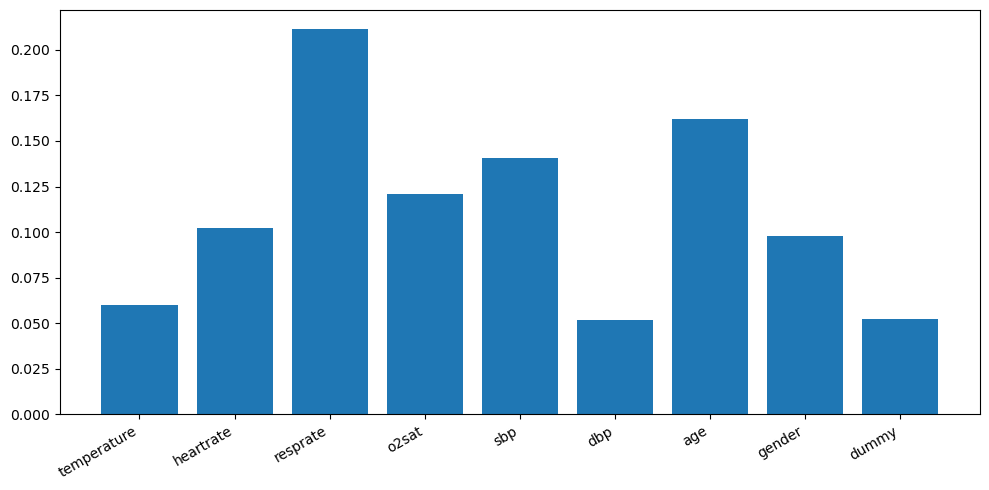

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.06028 |  0:00:00s
epoch 1  | loss: 0.90129 |  0:00:00s
epoch 2  | loss: 0.83336 |  0:00:00s
epoch 3  | loss: 0.78165 |  0:00:00s
epoch 4  | loss: 0.70254 |  0:00:00s
epoch 5  | loss: 0.68612 |  0:00:00s
epoch 6  | loss: 0.64046 |  0:00:00s
epoch 7  | loss: 0.59724 |  0:00:00s
epoch 8  | loss: 0.56976 |  0:00:00s
epoch 9  | loss: 0.54937 |  0:00:00s
epoch 10 | loss: 0.52639 |  0:00:00s
epoch 11 | loss: 0.50835 |  0:00:00s
epoch 12 | loss: 0.50697 |  0:00:00s
epoch 13 | loss: 0.49295 |  0:00:00s
epoch 14 | loss: 0.48722 |  0:00:00s
epoch 15 | loss: 0.48958 |  0:00:00s
epoch 16 | loss: 0.48821 |  0:00:00s
epoch 17 | loss: 0.49068 |  0:00:00s
epoch 18 | loss: 0.48542 |  0:00:00s
epoch 19 | loss: 0.46605 |  0:00:00s
epoch 20 | loss: 0.47594 |  0:00:00s
epoch 21 | loss: 0.47337 |  0:00:00s
epoch 22 | loss: 0.46503 |  0:00:00s
epoch 23 | loss: 0.46745 |  0:00:00s
epoch 24 | loss: 0.46533 |  0:00:00s
epoch 25 | loss: 0.45792 |  0:00:00s
epoch 26 | loss: 0.45349 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 6  | loss: 0.64046 |  0:00:00s
epoch 7  | loss: 0.59724 |  0:00:00s
epoch 8  | loss: 0.56976 |  0:00:00s
epoch 9  | loss: 0.54937 |  0:00:00s
epoch 10 | loss: 0.52639 |  0:00:00s
epoch 11 | loss: 0.50835 |  0:00:00s
epoch 12 | loss: 0.50697 |  0:00:00s
epoch 13 | loss: 0.49295 |  0:00:00s
epoch 14 | loss: 0.48722 |  0:00:00s
epoch 15 | loss: 0.48958 |  0:00:00s
epoch 16 | loss: 0.48821 |  0:00:00s
epoch 17 | loss: 0.49068 |  0:00:00s
epoch 18 | loss: 0.48542 |  0:00:00s
epoch 19 | loss: 0.46605 |  0:00:00s
epoch 20 | loss: 0.47594 |  0:00:00s
epoch 21 | loss: 0.47337 |  0:00:00s
epoch 22 | loss: 0.46503 |  0:00:00s
epoch 23 | loss: 0.46745 |  0:00:00s
epoch 24 | loss: 0.46533 |  0:00:00s
epoch 25 | loss: 0.45792 |  0:00:00s
epoch 26 | loss: 0.45349 |  0:00:00s
epoch 27 | loss: 0.46046 |  0:00:00s
epoch 28 | loss: 0.44997 |  0:00:00s
epoch 29 | loss: 0.44856 |  0:00:00s
epoch 30 | loss: 0.43694 |  0:00:00s
epoch 31 | loss: 0.43432 |  0:00:00s
epoch 32 | loss: 0.4321  |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 5  | loss: 0.68612 |  0:00:00s
epoch 6  | loss: 0.64046 |  0:00:00s
epoch 7  | loss: 0.59724 |  0:00:00s
epoch 8  | loss: 0.56976 |  0:00:00s
epoch 9  | loss: 0.54937 |  0:00:00s
epoch 10 | loss: 0.52639 |  0:00:00s
epoch 11 | loss: 0.50835 |  0:00:00s
epoch 12 | loss: 0.50697 |  0:00:00s
epoch 13 | loss: 0.49295 |  0:00:00s
epoch 14 | loss: 0.48722 |  0:00:00s
epoch 15 | loss: 0.48958 |  0:00:00s
epoch 16 | loss: 0.48821 |  0:00:00s
epoch 17 | loss: 0.49068 |  0:00:00s
epoch 18 | loss: 0.48542 |  0:00:00s
epoch 19 | loss: 0.46605 |  0:00:00s
epoch 20 | loss: 0.47594 |  0:00:00s
epoch 21 | loss: 0.47337 |  0:00:00s
epoch 22 | loss: 0.46503 |  0:00:00s
epoch 23 | loss: 0.46745 |  0:00:00s
epoch 24 | loss: 0.46533 |  0:00:00s
epoch 25 | loss: 0.45792 |  0:00:00s
epoch 26 | loss: 0.45349 |  0:00:00s
epoch 27 | loss: 0.46046 |  0:00:00s
epoch 28 | loss: 0.44997 |  0:00:00s
epoch 29 | loss: 0.44856 |  0:00:00s
epoch 30 | loss: 0.43694 |  0:00:00s
epoch 31 | loss: 0.43432 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.06028 |  0:00:00s
epoch 1  | loss: 0.90129 |  0:00:00s
epoch 2  | loss: 0.83336 |  0:00:00s
epoch 3  | loss: 0.78165 |  0:00:00s
epoch 4  | loss: 0.70254 |  0:00:00s
epoch 5  | loss: 0.68612 |  0:00:00s
epoch 6  | loss: 0.64046 |  0:00:00s
epoch 7  | loss: 0.59724 |  0:00:00s
epoch 8  | loss: 0.56976 |  0:00:00s
epoch 9  | loss: 0.54937 |  0:00:00s
epoch 10 | loss: 0.52639 |  0:00:00s
epoch 11 | loss: 0.50835 |  0:00:00s
epoch 12 | loss: 0.50697 |  0:00:00s
epoch 13 | loss: 0.49295 |  0:00:00s
epoch 14 | loss: 0.48722 |  0:00:00s
epoch 15 | loss: 0.48958 |  0:00:00s
epoch 16 | loss: 0.48821 |  0:00:00s
epoch 17 | loss: 0.49068 |  0:00:00s
epoch 18 | loss: 0.48542 |  0:00:00s
epoch 19 | loss: 0.46605 |  0:00:00s
epoch 20 | loss: 0.47594 |  0:00:00s
epoch 21 | loss: 0.47337 |  0:00:00s
epoch 22 | loss: 0.46503 |  0:00:00s
epoch 23 | loss: 0.46745 |  0:00:00s
epoch 24 | loss: 0.46533 |  0:00:00s
epoch 25 | loss: 0.45792 |  0:00:00s
epoch 26 | loss: 0.45349 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 3  | loss: 0.78165 |  0:00:00s
epoch 4  | loss: 0.70254 |  0:00:00s
epoch 5  | loss: 0.68612 |  0:00:00s
epoch 6  | loss: 0.64046 |  0:00:00s
epoch 7  | loss: 0.59724 |  0:00:00s
epoch 8  | loss: 0.56976 |  0:00:00s
epoch 9  | loss: 0.54937 |  0:00:00s
epoch 10 | loss: 0.52639 |  0:00:00s
epoch 11 | loss: 0.50835 |  0:00:00s
epoch 12 | loss: 0.50697 |  0:00:00s
epoch 13 | loss: 0.49295 |  0:00:00s
epoch 14 | loss: 0.48722 |  0:00:00s
epoch 15 | loss: 0.48958 |  0:00:00s
epoch 16 | loss: 0.48821 |  0:00:00s
epoch 17 | loss: 0.49068 |  0:00:00s
epoch 18 | loss: 0.48542 |  0:00:00s
epoch 19 | loss: 0.46605 |  0:00:00s
epoch 20 | loss: 0.47594 |  0:00:00s
epoch 21 | loss: 0.47337 |  0:00:00s
epoch 22 | loss: 0.46503 |  0:00:00s
epoch 23 | loss: 0.46745 |  0:00:00s
epoch 24 | loss: 0.46533 |  0:00:00s
epoch 25 | loss: 0.45792 |  0:00:00s
epoch 26 | loss: 0.45349 |  0:00:00s
epoch 27 | loss: 0.46046 |  0:00:00s
epoch 28 | loss: 0.44997 |  0:00:00s
epoch 29 | loss: 0.44856 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 6  | loss: 0.64046 |  0:00:00s
epoch 7  | loss: 0.59724 |  0:00:00s
epoch 8  | loss: 0.56976 |  0:00:00s
epoch 9  | loss: 0.54937 |  0:00:00s
epoch 10 | loss: 0.52639 |  0:00:00s
epoch 11 | loss: 0.50835 |  0:00:00s
epoch 12 | loss: 0.50697 |  0:00:00s
epoch 13 | loss: 0.49295 |  0:00:00s
epoch 14 | loss: 0.48722 |  0:00:00s
epoch 15 | loss: 0.48958 |  0:00:00s
epoch 16 | loss: 0.48821 |  0:00:00s
epoch 17 | loss: 0.49068 |  0:00:00s
epoch 18 | loss: 0.48542 |  0:00:00s
epoch 19 | loss: 0.46605 |  0:00:00s
epoch 20 | loss: 0.47594 |  0:00:00s
epoch 21 | loss: 0.47337 |  0:00:00s
epoch 22 | loss: 0.46503 |  0:00:00s
epoch 23 | loss: 0.46745 |  0:00:00s
epoch 24 | loss: 0.46533 |  0:00:00s
epoch 25 | loss: 0.45792 |  0:00:00s
epoch 26 | loss: 0.45349 |  0:00:00s
epoch 27 | loss: 0.46046 |  0:00:00s
epoch 28 | loss: 0.44997 |  0:00:00s
epoch 29 | loss: 0.44856 |  0:00:00s
epoch 30 | loss: 0.43694 |  0:00:00s
epoch 31 | loss: 0.43432 |  0:00:00s
epoch 32 | loss: 0.4321  |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.06028 |  0:00:00s
epoch 1  | loss: 0.90129 |  0:00:00s
epoch 2  | loss: 0.83336 |  0:00:00s
epoch 3  | loss: 0.78165 |  0:00:00s
epoch 4  | loss: 0.70254 |  0:00:00s
epoch 5  | loss: 0.68612 |  0:00:00s
epoch 6  | loss: 0.64046 |  0:00:00s
epoch 7  | loss: 0.59724 |  0:00:00s
epoch 8  | loss: 0.56976 |  0:00:00s
epoch 9  | loss: 0.54937 |  0:00:00s
epoch 10 | loss: 0.52639 |  0:00:00s
epoch 11 | loss: 0.50835 |  0:00:00s
epoch 12 | loss: 0.50697 |  0:00:00s
epoch 13 | loss: 0.49295 |  0:00:00s
epoch 14 | loss: 0.48722 |  0:00:00s
epoch 15 | loss: 0.48958 |  0:00:00s
epoch 16 | loss: 0.48821 |  0:00:00s
epoch 17 | loss: 0.49068 |  0:00:00s
epoch 18 | loss: 0.48542 |  0:00:00s
epoch 19 | loss: 0.46605 |  0:00:00s
epoch 20 | loss: 0.47594 |  0:00:00s
epoch 21 | loss: 0.47337 |  0:00:00s
epoch 22 | loss: 0.46503 |  0:00:00s
epoch 23 | loss: 0.46745 |  0:00:00s
epoch 24 | loss: 0.46533 |  0:00:00s
epoch 25 | loss: 0.45792 |  0:00:00s
epoch 26 | loss: 0.45349 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 2  | loss: 0.83336 |  0:00:00s
epoch 3  | loss: 0.78165 |  0:00:00s
epoch 4  | loss: 0.70254 |  0:00:00s
epoch 5  | loss: 0.68612 |  0:00:00s
epoch 6  | loss: 0.64046 |  0:00:00s
epoch 7  | loss: 0.59724 |  0:00:00s
epoch 8  | loss: 0.56976 |  0:00:00s
epoch 9  | loss: 0.54937 |  0:00:00s
epoch 10 | loss: 0.52639 |  0:00:00s
epoch 11 | loss: 0.50835 |  0:00:00s
epoch 12 | loss: 0.50697 |  0:00:00s
epoch 13 | loss: 0.49295 |  0:00:00s
epoch 14 | loss: 0.48722 |  0:00:00s
epoch 15 | loss: 0.48958 |  0:00:00s
epoch 16 | loss: 0.48821 |  0:00:00s
epoch 17 | loss: 0.49068 |  0:00:00s
epoch 18 | loss: 0.48542 |  0:00:00s
epoch 19 | loss: 0.46605 |  0:00:00s
epoch 20 | loss: 0.47594 |  0:00:00s
epoch 21 | loss: 0.47337 |  0:00:00s
epoch 22 | loss: 0.46503 |  0:00:00s
epoch 23 | loss: 0.46745 |  0:00:00s
epoch 24 | loss: 0.46533 |  0:00:00s
epoch 25 | loss: 0.45792 |  0:00:00s
epoch 26 | loss: 0.45349 |  0:00:00s
epoch 27 | loss: 0.46046 |  0:00:00s
epoch 28 | loss: 0.44997 |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 6  | loss: 0.64046 |  0:00:00s
epoch 7  | loss: 0.59724 |  0:00:00s
epoch 8  | loss: 0.56976 |  0:00:00s
epoch 9  | loss: 0.54937 |  0:00:00s
epoch 10 | loss: 0.52639 |  0:00:00s
epoch 11 | loss: 0.50835 |  0:00:00s
epoch 12 | loss: 0.50697 |  0:00:00s
epoch 13 | loss: 0.49295 |  0:00:00s
epoch 14 | loss: 0.48722 |  0:00:00s
epoch 15 | loss: 0.48958 |  0:00:00s
epoch 16 | loss: 0.48821 |  0:00:00s
epoch 17 | loss: 0.49068 |  0:00:00s
epoch 18 | loss: 0.48542 |  0:00:00s
epoch 19 | loss: 0.46605 |  0:00:00s
epoch 20 | loss: 0.47594 |  0:00:00s
epoch 21 | loss: 0.47337 |  0:00:00s
epoch 22 | loss: 0.46503 |  0:00:00s
epoch 23 | loss: 0.46745 |  0:00:00s
epoch 24 | loss: 0.46533 |  0:00:00s
epoch 25 | loss: 0.45792 |  0:00:00s
epoch 26 | loss: 0.45349 |  0:00:00s
epoch 27 | loss: 0.46046 |  0:00:00s
epoch 28 | loss: 0.44997 |  0:00:00s
epoch 29 | loss: 0.44856 |  0:00:00s
epoch 30 | loss: 0.43694 |  0:00:00s
epoch 31 | loss: 0.43432 |  0:00:00s
epoch 32 | loss: 0.4321  |  0:00:00s
e

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:688: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 3  | loss: 0.78165 |  0:00:00s
epoch 4  | loss: 0.70254 |  0:00:00s
epoch 5  | loss: 0.68612 |  0:00:00s
epoch 6  | loss: 0.64046 |  0:00:00s
epoch 7  | loss: 0.59724 |  0:00:00s
epoch 8  | loss: 0.56976 |  0:00:00s
epoch 9  | loss: 0.54937 |  0:00:00s
epoch 10 | loss: 0.52639 |  0:00:00s
epoch 11 | loss: 0.50835 |  0:00:00s
epoch 12 | loss: 0.50697 |  0:00:00s
epoch 13 | loss: 0.49295 |  0:00:00s
epoch 14 | loss: 0.48722 |  0:00:00s
epoch 15 | loss: 0.48958 |  0:00:00s
epoch 16 | loss: 0.48821 |  0:00:00s
epoch 17 | loss: 0.49068 |  0:00:00s
epoch 18 | loss: 0.48542 |  0:00:00s
epoch 19 | loss: 0.46605 |  0:00:00s
epoch 20 | loss: 0.47594 |  0:00:00s
epoch 21 | loss: 0.47337 |  0:00:00s
epoch 22 | loss: 0.46503 |  0:00:00s
epoch 23 | loss: 0.46745 |  0:00:00s
epoch 24 | loss: 0.46533 |  0:00:00s
epoch 25 | loss: 0.45792 |  0:00:00s
epoch 26 | loss: 0.45349 |  0:00:00s
epoch 27 | loss: 0.46046 |  0:00:00s
epoch 28 | loss: 0.44997 |  0:00:00s
epoch 29 | loss: 0.44856 |  0:00:00s
e

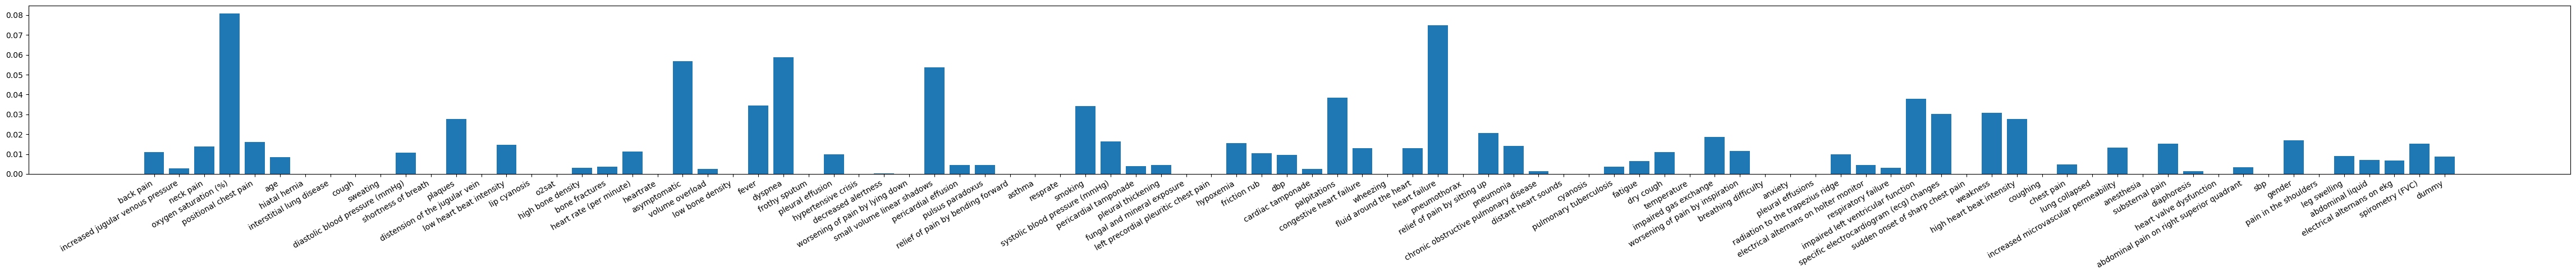

In [13]:
import os
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier
save_folder = os.path.join("generated", "aug_results")
prefix = "[all-lesions] [with-doc] [tabnet]"

result_df = []
features_sets = {
    "original": {
        "df": original_df,
        "cols": original_clinical_cols,
    },
    "augmented": {
        "df": merged_df,
        "cols": list(set(extended_clinical_features)),
    },
}
models = {
    # "DecisionTree": DecisionTreeClassifier,
    # "RandomForest": RandomForestClassifier,
    # "XGBoost": xgb.XGBClassifier,
    "TabNet": TabNetMultiTaskClassifier
}

for f_k, f_v in features_sets.items():
    for m_k, m_v in models.items():
        result = get_summary(
            f_v["df"],
            f_v["cols"] + ["dummy"],
            TOP5_LABEL_COLS,
            m_v,
        )

        # append the dataframe
        # save fig
        result["fi_fig"].savefig(os.path.join(save_folder, f"{prefix} [{f_k}][{m_k}].png"))
        result_df.append(
            OrderedDict(
                {
                    "Feature Set": f_k,
                    "Model": m_k,
                    "Accuracy": result["accuracy"],
                    "AUC": result["AUC"],
                    "#fi>dummy": result["#fi>dummy"],
                    "fi>dummy": result["fi>dummy"],
                }
            )
        )

In [14]:
# pred = Debugger.pred
# df = Debugger.df
# label_cols = TOP5_LABEL_COLS
# pred = np.array(pred).astype(np.float32).transpose(1,0)
# mla = MultilabelAccuracy(num_labels=len(label_cols), average="micro")
# acc = mla(
#     torch.tensor(pred),
#     (torch.tensor(np.array(df[df["split"] == "test"][label_cols] > 0))).float(),
# )

In [15]:
pd.DataFrame(result_df)

,Feature Set,Model,Accuracy,AUC,#fi>dummy,fi>dummy
0,original,TabNet,0.686486±0.000000,0.568090±0.000000,7,"[temperature, heartrate, resprate, o2sat, sbp,..."
1,augmented,TabNet,0.705405±0.000000,0.613595±0.000000,37,"[back pain, neck pain, oxygen saturation (%), ..."


In [16]:
pd.DataFrame(result_df).to_csv(os.path.join(save_folder, "{prefix} result.csv"))